# Adding new objects to Nengo

It is possible to add new objects
to the Nengo reference simulator.
This involves several steps and the creation
of several objects.
In this example, we'll go through these steps
in order to add a new neuron type to Nengo:
a rectified linear neuron.

## Step 1: Create a frontend Neurons subclass

The `RectifiedLinear` class is what you will use
in model scripts to denote that a particular ensemble
should be simulated using a rectified linear neuron
instead of one of the existing neuron types (e.g., `LIF`).

Normally, these kinds of frontend classes exist
in either `nengo/objects.py` or `nengo/neurons.py`.
Look at these files for examples of how to make your own.
In this case, because we're making a neuron type,
we'll use `nengo.neurons.LIF` as an example
of how to make `RectifiedLinear`.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

import nengo
from nengo.builder import Builder
from nengo.builder.operator import Operator
from nengo.utils.ensemble import tuning_curves


# Neuron types must subclass `nengo.neurons.NeuronType`
class RectifiedLinear(nengo.neurons.NeuronType):
    """A rectified linear neuron model."""

    # We don't need any additional parameters here;
    # gain and bias are sufficient. But, if we wanted
    # more parameters, we could accept them by creating
    # an __init__ method.

    def gain_bias(self, max_rates, intercepts):
        """Return gain and bias given maximum firing rate and x-intercept."""
        gain = max_rates / (1 - intercepts)
        bias = -intercepts * gain
        return gain, bias

    def step_math(self, dt, J, output):
        """Compute rates in Hz for input current (incl. bias)"""
        output[...] = np.maximum(0., J)

## Step 2: Create a backend Operator subclass

The `Operator` (located in `nengo/builder.py`) defines
the function that the reference simulator will execute
on every timestep. Most new neuron types and learning rules
will require a new `Operator`, unless the function
being computed can be done by combining several
existing operators.

In this case, we will make a new operator
that outputs the firing rate of each neuron
on every timestep.

Note that for neuron types specifically,
there is a `SimNeurons` operator that
calls `step_math`. However, we will
implement a new operator here to demonstrate
how to build a simple operator.

In [2]:
class SimRectifiedLinear(Operator):
    """Set output to the firing rate of a rectified linear neuron model."""

    def __init__(self, output, J, neurons, tag=None):
        super().__init__(tag=tag)
        self.neurons = neurons  # The RectifiedLinear instance

        # Operators must explicitly tell the simulator what signals
        # they read, set, update, and increment
        self.reads = [J]
        self.updates = [output]
        self.sets = []
        self.incs = []

    @property
    def output(self):
        """Output signal of the ensemble."""
        return self.updates[0]

    @property
    def J(self):
        return self.reads[0]

    # If we needed additional signals that aren't in one of the
    # reads, updates, sets, or incs lists, we can initialize them
    # by making an `init_signals(self, signals, dt)` method.

    def make_step(self, signals, dt, rng):
        """Return a function that the Simulator will execute on each step.

        `signals` contains a dictionary mapping each signal to
        an ndarray which can be used in the step function.
        `dt` is the simulator timestep (which we don't use).
        """
        J = signals[self.J]
        output = signals[self.output]

        def step_simrectifiedlinear():
            # Gain and bias are already taken into account here,
            # so we just need to rectify
            output[...] = np.maximum(0, J)

        return step_simrectifiedlinear

## Step 3: Create a build function

In order for `nengo.builder.Builder`
to construct signals and operators
for the Simulator to use,
you must create and register a build function
with `nengo.builder.Builder`.
This function should take as arguments
a `RectifiedLinear` instance,
some other arguments specific to the type,
and a `nengo.builder.Model` instance.
The function should add the approrpiate
signals, operators, and other artifacts
to the `Model` instance,
and then register the build function
with `nengo.builder.Builder`.

In [3]:
@Builder.register(RectifiedLinear)
def build_rectified_linear(model, neuron_type, neurons):
    model.operators.append(
        SimRectifiedLinear(
            output=model.sig[neurons]['out'],
            J=model.sig[neurons]['in'],
            neurons=neuron_type))

Now you can use `RectifiedLinear` like any other neuron type!

## Tuning curves

We can build a small network just to see the tuning curves.

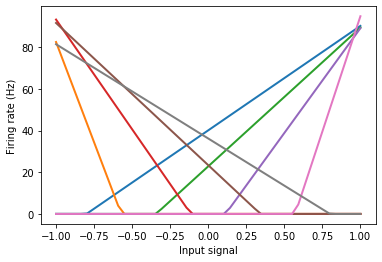

In [4]:
model = nengo.Network()
with model:
    encoders = np.tile([[1], [-1]], (4, 1))
    intercepts = np.linspace(-0.8, 0.8, 8)
    intercepts *= encoders[:, 0]
    A = nengo.Ensemble(
        8, dimensions=1,
        intercepts=intercepts,
        neuron_type=RectifiedLinear(),
        max_rates=nengo.dists.Uniform(80, 100),
        encoders=encoders)
with nengo.Simulator(model) as sim:
    eval_points, activities = tuning_curves(A, sim)
plt.figure()
plt.plot(eval_points, activities, lw=2)
plt.xlabel("Input signal")
plt.ylabel("Firing rate (Hz)");

## 2D Representation example

Below is the same model as is made in the 2d_representation example,
except now using `RectifiedLinear` neurons insated of `nengo.LIF`.

In [5]:
model = nengo.Network(label='2D Representation', seed=10)
with model:
    neurons = nengo.Ensemble(100, dimensions=2, neuron_type=RectifiedLinear())
    sin = nengo.Node(output=np.sin)
    cos = nengo.Node(output=np.cos)
    nengo.Connection(sin, neurons[0])
    nengo.Connection(cos, neurons[1])
    sin_probe = nengo.Probe(sin, 'output')
    cos_probe = nengo.Probe(cos, 'output')
    neurons_probe = nengo.Probe(neurons, 'decoded_output', synapse=0.01)
with nengo.Simulator(model) as sim:
    sim.run(5)

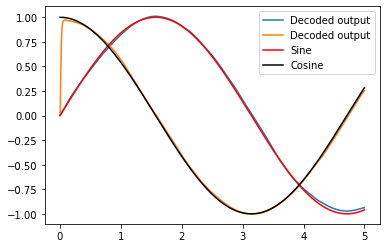

In [6]:
plt.figure()
plt.plot(sim.trange(), sim.data[neurons_probe], label="Decoded output")
plt.plot(sim.trange(), sim.data[sin_probe], 'r', label="Sine")
plt.plot(sim.trange(), sim.data[cos_probe], 'k', label="Cosine")
plt.legend();